# MetPy's Meteorological Data Parsing Abilities: From Surface to Upper Air

---

### Authors: [Max Grover](https://mgrover1.github.io/) and [Ryan May](https://staff.ucar.edu/users/rmay)

### **Questions**

1. How can MetPy's METAR parser be used to accesss surface observations?
2. How can MetPy be used to extract upper-air data from TTAAs (*not yet officially supported*)?
3. How can surface maps and upper-air maps be generated using MetPy's declarative syntax?

### **Objectives**
1. <a href="#metarparse">Parse a METAR text file to obtain surface data</a>
2. <a href="#surfacemap">Creating a surface map</a>
3. <a href="#ttaaparse">Parse a TTAA text file to obtain upper-air data</a>
4. <a href="#upperairmap">Creating an upper-air map</a>


---
<a name="metarparse"></a>
## Parse a METAR text file to obtain surface data

### What is a METAR?
- Stands for METerological Aerodrome Report
- Stores surface data from stations around the globe
- World Meteorological Organization standard data format

### Example METAR
<img src="metar_diagram.png" width="500" height="500">

### First, install the additional libraries needed - wget and MetPy if you have not already

In [1]:
from datetime import datetime
import wget

from metpy.io.metar import parse_metar_file
from metpy.units import units

from upper_air import parse_ttaa_file

#### **Determine which time to use, download the file, and parse the METARs**
Data are from the [Unidata Thredds Test Server](https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.html) which includes data from thirty days in the past to current observations

Another data source is the [Iowa State ASOS Archive](https://mesonet.agron.iastate.edu/request/download.phtml), although there is pre-processing neccessary to determine sky cover and weather symbols

In [2]:
# Select the date 
#time = datetime.utcnow()

# You can also input your own date - be aware that the Thredds test server contains data from past 30 days
time = datetime(2020, 6, 25, 12)

# Grab the surface data
url = time.strftime('https://thredds-test.unidata.ucar.edu/thredds/fileServer/noaaport/text/metar/metar_%Y%m%d_%H00.txt')
file = wget.download(url)
sfc_data = parse_metar_file(file)

/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/metpy/calc/basic.py:1013: UserWarning: Input over 12.566370614359172 radians. Ensure proper units are given.
  'Ensure proper units are given.'.format(max_radians))


In [3]:
from metpy.units import units

sfc_data['air_temperature']  = (sfc_data['air_temperature'].values * units(sfc_data.units['air_temperature'])).to('degF')
sfc_data['dew_point_temperature'] = (sfc_data['dew_point_temperature'].values * units(sfc_data.units['dew_point_temperature'])).to('degF')

<a name="surfacemap"></a>
## Creating a surface map

For this plot we need a single panel and we want to plot the surface obs, so we'll use the `PlotObs`.

In [4]:
import metpy.plots as mpplots

# Create the PlotObs object
obs = mpplots.PlotObs()

# Use the dataframe created previously as the input data
obs.data = sfc_data

# Add time
obs.time = time

# Set level to none since data is at surface
obs.level = None

# Specify which fields to plot
obs.fields = ['air_temperature', 'dew_point_temperature', 'air_pressure_at_sea_level', 'cloud_coverage', 'present_weather', 'past_weather']

# Set locations for each variable
obs.locations = ['NW', 'SW', 'NE', 'C', 'W', 'SE']

# Specify format for each variable and utilize weather symbol
obs.formats = [None, None, lambda v: format(10 * v, '.0f')[-3:], 'sky_cover',
               'current_weather', 'current_weather']

# Add colors to each field - if commented out, plot will be black and white
obs.colors = ['red', 'green', 'black', 'black', 'blue', 'blue']

# Plot winds
obs.vector_field = ('eastward_wind', 'northward_wind')

# Reduce the point density
obs.reduce_points = 1

Next, we'll make the panel that our image will go into, the `MapPanel` object and add the image to the plots on the panel.

In [5]:
import cartopy.crs as ccrs

panel = mpplots.MapPanel()
panel.layout = (1, 1, 1)

# The area which is shown on the plot - states and other regions can be used as well
panel.area = 'tx'

# Use a Lambert Conformal Projection
panel.projection = 'lcc'

# Plot coastline, borders, and states
panel.layers = ['coastline', 'borders', 'states']

# Include the PlotObs plot in this panel
panel.plots = [obs]

# Add a title
panel.title = 'Surface Map: Temp(F), Dewp(F), MSLP(hPa), Cloud Cover (Oktas), and Current Weather'

Finally, we make the `PanelContainer` and add the panel to its container 

/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1913: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1913: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


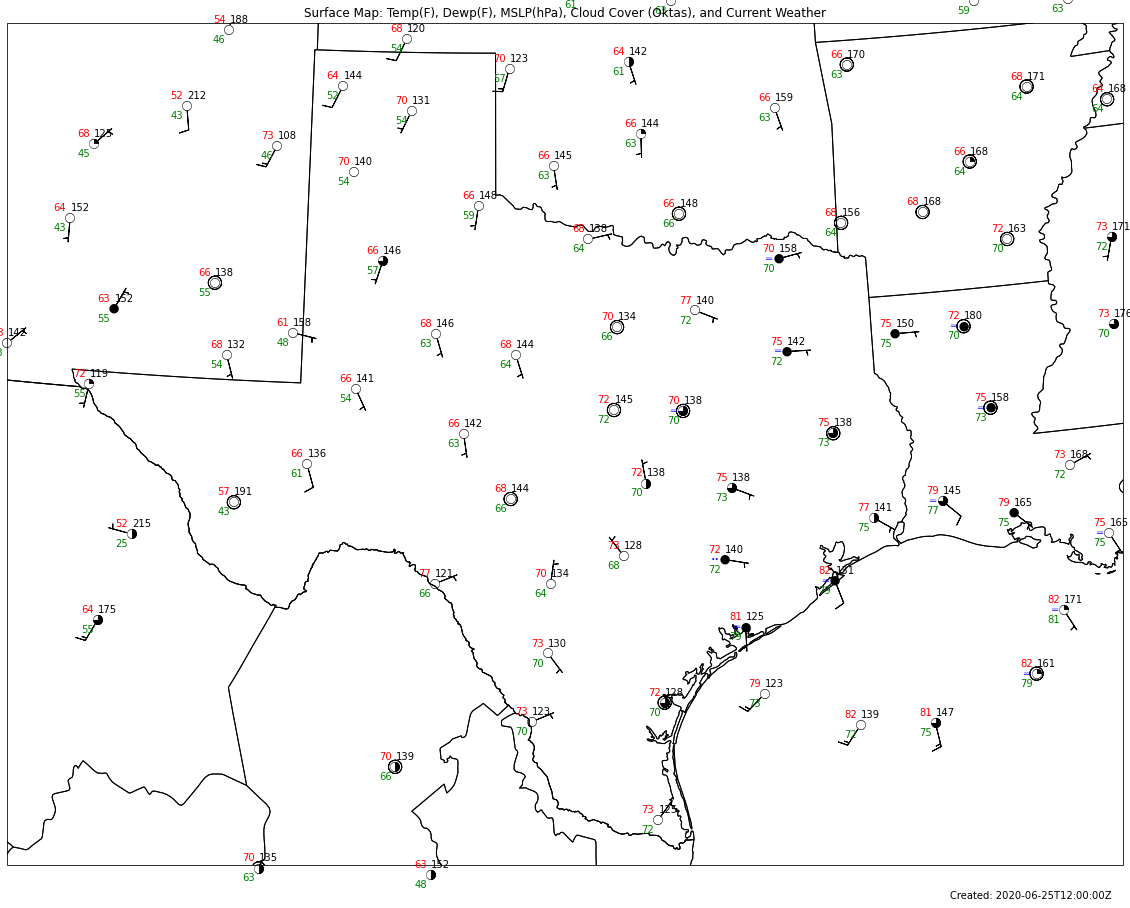

In [6]:
pc = mpplots.PanelContainer()
pc.size = (20, 20)
pc.panels = [panel]

# Add a timestamp
mpplots.add_timestamp(panel.ax, time=time)

pc.show()

---
<a name="ttaaparse"></a>
## Parse a TTAA text file to obtain upper-air data

### What is a TTAA?
- A section within radiosonde data which contains the mandatory levels (ex. 500 hPa)
- Collected by radiosondes on weather balloons
- Typically reported twice a day - 00 UTC and 12 UTC

### [Decoding guide provided by Iowa State University](https://meteor.geol.iastate.edu/classes/mt311/extras/Codul-TEMP.pdf)


#### **Determine which time to use, download the file, and parse the METARs**
Data are from the [Unidata Thredds Test Server](https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/upper_air/upper_air.html) which includes data from thirty days in the past to current observations

In [7]:
# You can also input your own date - be aware that the Thredds test server contains data from past 30 days
time = datetime(2020, 6, 25, 12)

# Grab the upper-air data - the parser has not yet been merged with MetPy, so the module is stored locally
url = time.strftime('https://thredds-test.unidata.ucar.edu/thredds/fileServer/noaaport/text/upper_air/upper_air_%Y%m%d_%H00.txt')
file = wget.download(url)
upper_air_data = parse_ttaa_file(file)

<a name="upperairmap"></a>
## Creating an Upper-Air Map

For this plot we need a single panel and we want to plot the surface obs, so we'll use the `PlotObs`.

In [8]:
obs = mpplots.PlotObs()
obs.data = upper_air_data
obs.time = time
obs.level = 500 * units.hPa
obs.fields = ['temperature', 'dewpoint', 'height']
obs.locations = ['NW', 'SW', 'NE']
obs.formats = [None, None, lambda v: format(v, '.0f')[:3]]
obs.vector_field = ('u_wind', 'v_wind')
obs.reduce_points = 0

Next, we'll make the panel that our image will go into, the `MapPanel` object and add the image to the plots on the panel.

In [9]:
# Add map features for the particular panel
panel = mpplots.MapPanel()
panel.layout = (1, 1, 1)
panel.area = (-124, -72, 20, 53)
panel.projection = 'lcc'
panel.layers = ['coastline', 'borders', 'states', 'land', 'ocean']
panel.plots = [obs]

Finally, we make the `PanelContainer` and add the panel to its container 

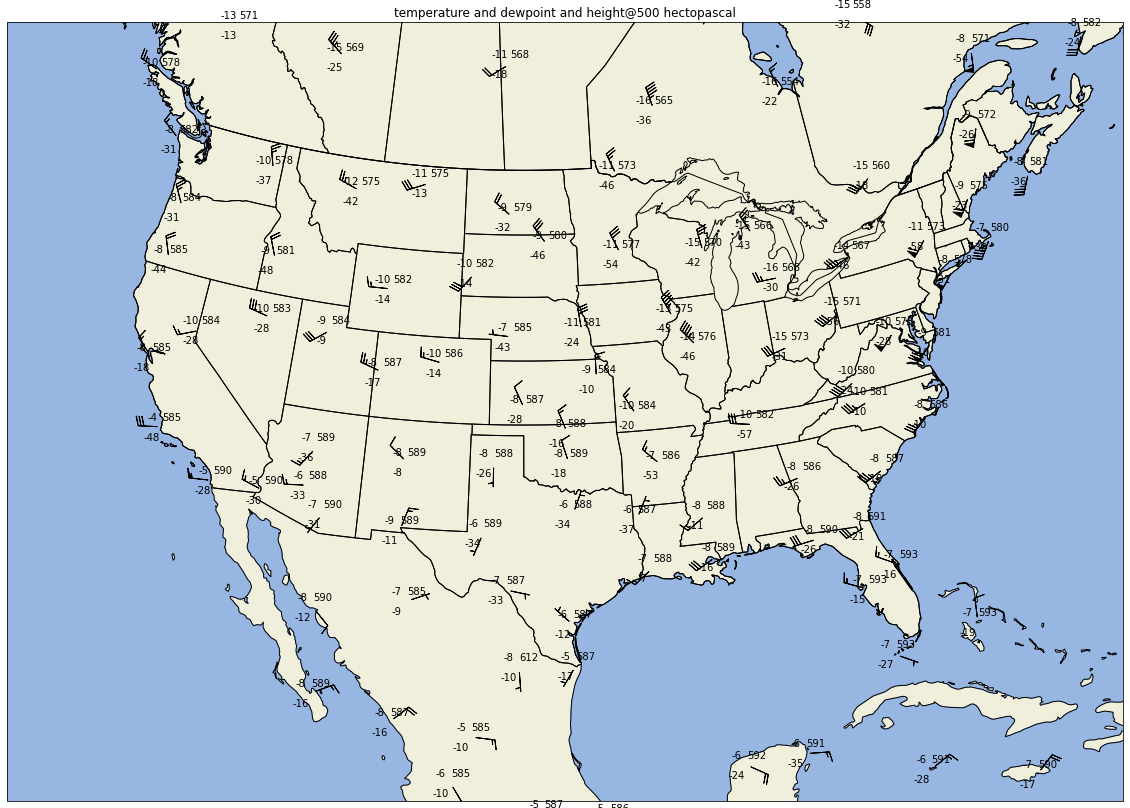

In [10]:
# Collecting panels for complete figure
pc = mpplots.PanelContainer()
pc.size = (20, 20)
pc.panels = [panel]

# Showing the results
pc.show()